# SBNet : Sparse Block Network([arxiv](https://arxiv.org/abs/1801.02108))

CNNs are widely used for analyzing visual imagery and data from LiDAR sensors. In autonomous driving, CNNs allow self-driving vehicles to see other cars and pedestrians, determine their exact locations, and solve many other difficult problems that could not previously be tackled with conventional algorithms. To ensure that our autonomous systems are reliable, such applications of CNNs must run at extremely fast speeds on GPUs. Developing efficient ways to improve response time and accuracy while reducing device costs and power consumption with CNNs is an ongoing research priority.   

The development of model architectures and algorithms in the field of deep learning is largely constrained by the availability of efficient GPU implementations of elementary operations. One issue has been the lack of an efficient GPU implementation for sparse linear operations.

Conventional deep CNNs apply convolution operators uniformly for all spatial locations across hundreds of layers, requiring trillions of operations per second. The knowledge that many of these operations are wasted on over analyzing irrelevant information. In a typical scene, only a small percentage of observed data is important, this is sparsity. The way we see, the visual cortex exploits sparsity by focusing foveal vision based on movement detected in the peripheral vision and reducing receptor density and color information in the peripheral portions of the retina.

SBnet forces the CNN's to focus (attention) only on the object in the image, using a mask. Since, the rest of the image is blocked from its view (not given as input), CNN's don't convolve over these sparse regions. Thereby, reducing the number of compute operations.


![attention_blocks](https://github.com/Sharwon/EIP/raw/master/final_project/images/sbnet.gif "http://www.cs.toronto.edu/~byang/")

---

## Paper Notes

 - SBnet proposes to reduce computation in the high resolution main network using low-cost computation mask. Here, low-cost means, generating masks using very less resources.
 
 - It leverages the spatial sparsity structure of the mask.
 
 - The two main contributions of this paper are
         1. Tiling-based sparse convolution algorithm.
         2. Implementation of their sparse block algorithm using custom CUDA kernels.
 
 - The spatial sparsity can be represented as **binary** computation mask where ones indicate active locations that need more computation and zeros inactive.
 
 - These computation masks can be considered as attention mechanism where the attention weights are binary. These are used to guide the convolution filters.
 - SBnet computes convolution on a **blockwise** decomposition of the mask.
 - It gathers block-wise slices from tensors, and maintains the tensor shape. Within each active block, it performs a regular convolution, and uses **Winograd convolutions** for further speedup.
 - Block sparsity is defined in terms of a mask that can be known upfront like a priori sparsity structure, or that can be computed easily. (as mentioned before)
 - The same **sparsity mask** is reused for every layer, but uses reduced **spatial block** sizes at different spatial scales. It helps in maintaining speed without loss in accuracy.
 - Two major building blocks in sparse block-wise convolution-
   ![image1](https://github.com/Sharwon/EIP/raw/master/final_project/images/tiling-algo.png "Credits to paper")
      1. **Reduce mask to indices** : It converts the binary mask [H, W, C] (input) to a list of indices[B,3], where each indices references the location of the active blocks in the input tensor. The bock size is uniform, so that the gathered blocks can be batched together and passed into a convolution operation. After getting the appropriate block and overlap sizes, we perform a pooling(max/avg) operation followed by a threshold to downsample the input mask. We extract the patches from the non-zero locations.
      
   ![image2](https://github.com/Sharwon/EIP/raw/master/final_project/images/block-sparse.png "Credits to paper")
      2. **Sparse gather/scatter** : Gathering extracts a block[B, h, w, C] from the input tensor [N, H, W, C], using the generated indexes[B,3]. Unlike, tf.gather_nd(other gather kernel), this expands spatially to their neighborhood windows. The input overlap is essential to producing the output that seamlessly stitches the results of adjacent block convolution in a way that is locally equivalent to a dense convolution on a larger block and fused indexing capability is fundamental to practical speedup. The Scatter operation is inverse to the gather operation, reusing the same input mask and block index list. Input tensor [B, h`, w`, C] is the result after a series of convolution from the output of gather kernel, then a valid convolution is applied on the input tensor. The results of this convolution is copied back on the top of the dense activation tensor. 
     
  - A single residual layer has 3 convolutions, BatchNorm and Relu layers. All 9 layers can share a single gathering and scattering operation without block overlap, because it retains the same receptive field.
    
   ![image3](https://github.com/Sharwon/EIP/raw/master/final_project/images/residualsparseblock.png "Credits to paper")
  - We need to train Resnet-Sbnet end to end as BatchNorm statics differ for sparse connections. The gradient for scatter operation is the gather operation with the same precomputed block indices executed on the next layers backpropagated gradient tensor and vice versa. Also, keep in mind the edges of overlapping tiles.
  - **Custom Cuda Kernels**, were necessary to achieve speed-ups in practice. To minimize the intermediate outputs between kernels, they **fused downsample and indexing kernels** into one. Also **fused transpose + gather/scatter kernels**, as cuDNN runs faster with NCHW format. The gather/scatter kernel fuses the transpose from NHWC to NCHW tensor data inside the CUDA kernel. This is instrumental in achieving practical speed (eliminating transpose round-up trip). They were adamant in using NHWC format as it allows for memory-coalesced-contiguous access of spatially perforated blocks. **fused scatter-add kernel for residual blocks** helps in achieving faster inference time, by eliminating the extra memory allocation(reused output).
    ![image5](https://github.com/Sharwon/EIP/raw/master/final_project/images/tfopscustomcuda.png)
  - They implemented custom TensorFlow Ops to interface with the Cuda kernels.
  - It's benchmarked with sparse manifold convolution. Both layerwise and network benchmarks are compared.
  - The experiments and results are discussed a later section of this notebook.
  
  ---

## Input Dataset


I've downloaded a video from youtube, which records a road lane.  
Let's generate a dataset which has two classes (vehicles, no_vehicles) and their respective mask. It should look something like this.

![Image2](https://camo.githubusercontent.com/2328970cc768f21d5c7591fbccea6dff42a4df8d/687474703a2f2f692e67697068792e636f6d2f35413934415a61685349564f772e676966)

There are many techniques to realize this problem statement. Basically, we have to make a mask for moving objects.  
The simplest way to achieve this is by using foreground detection using background subtraction technique. Where in we take the first frame as the reference frame, and detect changes, by subtracting it from the next frame. For more details checkout the references at the end of this notebook.


In [ ]:
def create_dataset(video_file):
    '''
    Input : location of the video input (video_file)
    Output : Creates folders(sorted images) inside your directory depending upon the classes and masks
    '''
    cap = cv2.VideoCapture(video_file)

    count = 0
    #  VIDEO PROPERTIES
    print("Frame Width : ")
    print(cap.get(3))  # Frame Width
    print("Frame Height :")
    print(cap.get(4))  # Frame Height
    fps = (cap.get(cv2.CAP_PROP_FPS))
    print("FPS :", fps)
    # create a mask from the extacted frame.
    fullmask = cv2.createBackgroundSubtractorMOG2()
    while (cap.isOpened):
        ret, frame = cap.read()
        fgmask = fullmask.apply(frame)
        if fgmask is None:
            break
        (im2, contours, hierarchy) = cv2.findContours(fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            if cv2.contourArea(c) < 600: # removes smaller moving objects.
                continue

            filename_frame = "/Users/ubuntu/files/frames/frame_%d.jpg" % count
            # resize image
            resized_frame = cv2.resize(frame, (128,128), interpolation=cv2.INTER_AREA)
            cv2.imwrite(filename, resized_frame)

            filename_mask = "/Users/ubuntu/files/fgmask/fgmask_%d.jpg" % count
            # resize image
            resized_fgmask = cv2.resize(fgmask, (128,128), interpolation=cv2.INTER_AREA)
            # writing the image to a file.
            cv2.imwrite(filename, resized_fgmask)
            count = count + 1

        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

My initial result....  
![gif](https://github.com/Sharwon/EIP/raw/master/final_project/images/background.gif)

Now from the generated images and mask. I sorted images into four folders.  
vehicles, vehicles_mask, no_vehicles, no_vehicles_mask are the respective folders.

In [ ]:
#Saving the images as tensor files.
def convert_i2t(ROOT_DIR, STORE_DIR):
    '''
    ROOT_DIR : The directory of the image files.
    STORE_DIR : The directory of the saved image files.
    '''
    def save(fname, save_loc):
        '''
        fname : file name of the image
        save_loc : location where the pickle files are to be stores.
        '''
        sfile = bz2.BZ2File(fname, 'w')
        pickle.dump(save_loc, sfile)
        sfile.close()


    def process(DIR, STORE_DIR = "numpy_array/", color = 1):
        '''
        DIR : Directory which contains the images
        color : 1 reads in RGB, 0 reads in greyscale 
        '''
        image_list = os.listdir(os.path.join(ROOT_DIR, DIR))
        image_list.sort()
        for i in range(len(image_list)) :
            if i == 0 :
                img = cv2.imread(os.path.join(ROOT_DIR, DIR, image_list[i]), color)
                img_shape = img.shape 
                #torch expects tensors in shape N,C,H,W unlike keras,(N,H,W,C)
                data = np.empty((0, img_shape[2], img_shape[0], img_shape[1]))
                img = np.swapaxes(img, 0, 2)
                img = np.swapaxes(img, 1, 2)
                data = np.concatenate((data, img[np.newaxis, :, :, :]), axis = 0)
            else :
                img =  cv2.imread(os.path.join(ROOT_DIR, DIR, image_list[i]), color)
                img = np.swapaxes(img, 0, 2)
                img = np.swapaxes(img, 1, 2)
                data = np.concatenate((data, img[np.newaxis, :, :, :]), axis = 0)
        save(STORE_DIR + DIR + ".bz2", data)	
        return data


    data_list = os.listdir(ROOT_DIR)
    print(data_list)

    for i in data_list:
        process(i)

In [7]:
# the output should be like this, below.

['no_vehicles_frames', 'vehicles_frames', 'no_vehicles_mask', 'vehicles_fgmask']


---
## Code Inference

I've created a dataset of two classes. 20 images and 20 masks for each class.  
I have done experiments with other datasets as well, links are provided in the log's section.  
Where you can shift+enter the whole notebook in google colab.  

### Importing Libraries

In [5]:
# data loading and pre-processing
import pickle
import bz2
import os
#image processing tools
import numpy as np 
import cv2
from IPython.display import Image
#deep learning framework
import torch 
import torch.nn as nn
import numpy as np 
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
#ploting images
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#plt.style.use('ggplot')
%matplotlib inline

import ipdb

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Creating and Importing the Dataset

In [ ]:
# recommended to run these functions seperately, as a python script.

#creating dataset as mentioned before.
create_dataset("location of the video file")

'''
Sorted images into four folders.
vehicles, vehicles_mask, no_vehicles, no_vehicles_mask are the respective folders.
'''

# convert these images into b2z file (for loading them as numpy arrays)
convert_i2t(ROOT_DIR, STORE_DIR)

Loading the saved bz2 files into a torch tensor.

You can download the dataset form [here](https://github.com/Sharwon/EIP/blob/master/final_project/images_sbnet_smaple.zip) and run from the next cell, onwards. Don't forget to unzip and 'cd' into the folder.

In [6]:
# Loading the saved bz2 files
def loadBz2(name): 
	load_file = bz2.BZ2File(name, 'rb')
	data = pickle.load(load_file)
	load_file.close()
	return data


no_vehicles = loadBz2("numpy_array/no_vehicles_frames.bz2")
no_vehicles_mask = loadBz2("numpy_array/no_vehicles_fgmask.bz2")
vehicles = loadBz2("numpy_array/vehicles_frames.bz2")
vehicles_mask = loadBz2("numpy_array/vehicles_fgmask.bz2")

# Converting them to torch tensor
no_vehicles = torch.Tensor(no_vehicles).to(device)
no_vehicles_mask = torch.Tensor(no_vehicles_mask).to(device)
vehicles = torch.Tensor(vehicles).to(device)
vehicles_mask = torch.Tensor(vehicles_mask).to(device)
print(no_vehicles.size())
print(no_vehicles_mask.size())
print(vehicles.size())
print(vehicles_mask.size())

#The shape should be N,C,H,W (pytorch format)
#The model and the data must be on the same device.

torch.Size([20, 3, 128, 128])
torch.Size([20, 3, 128, 128])
torch.Size([20, 3, 128, 128])
torch.Size([20, 3, 128, 128])


In [7]:
# Making the training data into a pytorch readable format.

X_train = torch.cat((vehicles, no_vehicles), 0).to(device)
Y_train = torch.cat((torch.zeros(20,1), torch.ones(20,1)), 0).to(device)
#normalizing the dataset
X_train = X_train/255
Mask = torch.cat((vehicles_mask, no_vehicles_mask), 0).to(device)
Mask_t = (Mask > (10/255)).float()
Mask_t = Mask_t[:,0,:,:] # the mask format [B,H,W]
Mask_t.requires_grad = False

In [6]:
X_train.shape #[N,C,H,W]

torch.Size([40, 3, 128, 128])

In [7]:
Mask_t.shape #[N,H,W]

torch.Size([40, 128, 128])

In [8]:
mask_t=Mask_t.clone()
mask_t[Mask_t==0]=1
mask_t[Mask_t==1]=0
mask_t.requires_grad = False
mask_t.shape

torch.Size([40, 128, 128])

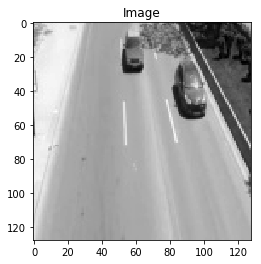

In [14]:
# image
plt.imshow(X_train[7,0, :, :])
plt.set_cmap(cmap = cm.gray)
plt.title("Image")
plt.show()

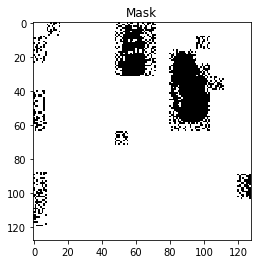

In [9]:
# image's mask
plt.imshow(mask_t[7, :, :])
plt.set_cmap(cmap = cm.gray)
plt.title("Mask")
plt.show()

In [10]:
# learning parameters
num_epochs = 5
num_classes = 2
batch_size = 4
learning_rate = 0.01
img_channel, img_height, img_width = X_train.shape[1], X_train.shape[2], X_train.shape[3]

### Custom SBnet Module Functions

In [11]:
def pad_input(input, ksize, kstride):
    '''
    Pads the input or mask according to the required kernel to perform sparse convolution

    Inputs:
    :param input:  torch tensor  #[N,H,W] binary mask or [N,C,H,W] input, where N is batch diemension, W, H are width and height of mask and C is channels
    :param kszie:  [list, tuple]  #[h,w] Size of kernel to perform pooling
    :param kstride:  [list, tuple]  #[h_stride,w_stride] Stride of Kernel

    Output: Zero padded torch tensor
    '''
    assert torch.is_tensor(input) == True, 'Expect input to be a pytorch tensor'
    isize = list(input.size())
    assert len(input.size()) == 3 or len(input.size()) == 4, 'Expect input rank = 3(mask) or 4(input)'
    assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
    assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
    assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'

    #padding along width!
    pad_w = kstride[-1] - ((isize[-1]-ksize[-1])%kstride[-1])
    pad_w1 = pad_w2 = pad_w//2
    if pad_w%2 == 1:
        pad_w2 += 1

    #padding along height
    pad_h = kstride[-2] - ((isize[-2]-ksize[-2])%kstride[-2])
    pad_h1 = pad_h2 = pad_h//2
    if pad_h%2 == 1:
        pad_h2 += 1

    pad = (pad_w1, pad_w2, pad_h1, pad_h2)
    return F.pad(input, pad, "constant", 0).to(device)

In [12]:
def reduce_mask_pool2d(mask, ksize, kstride, thresh = 0.2, avg= True):
    '''
    Reduce mask operation:Takes a binary mask as input and after performing 
    avg pooling or max pooling selects active blocksand return indices of 
    the active blocks

    Inputs:
    :param mask:  torch tensor  #[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask
    :param kszie:  [list, tuple]  #[h,w] Size of kernel to perform pooling
    :param kstride:  [list, tuple]  #[h_stride,w_stride] Stride of Kernel
    :param thresh:  int   #applicable for avg pooling
    :param avg:  bool   #Avg pooling or max pooling 

    Require_grad = Fasle

    Output:
        indicies of size [B, 3] where B is the number of active blocks 
        and 3 corresponds to [N, y, x] where N is batch size, and (y,x) is the 
        co-ordinates of the "centre" of the block.
        indicies is a torch tensor
    Note:
        padding is done automatically
    '''

    assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
    isize = list(mask.size())
    assert len(mask.size()) == 3 , 'Expect input rank = 3'
    assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
    assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
    assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
    assert type(thresh) in [int, float], 'Expect `thresh` to be int or float'

    mask = mask.unsqueeze(1)

    if avg:
        temp = F.avg_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
        indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
        indices = (indicesm != 0).nonzero().to(device)
        return indices
    else:
        temp = F.max_pool2d(input = mask, kernel_size = ksize, stride = kstride, padding = 0).to(device).squeeze()
        indicesm = torch.where(temp > thresh, torch.ones_like(temp).to(device), torch.zeros_like(temp).to(device)).int()
        indices = (indicesm != 0).nonzero().to(device)
        return indices

In [13]:
def mask_pool2d(mask):
    '''
    mask downsample operation:Takes a binary mask as input and performs max
    pooling to reduce its size 

    Inputs:
    :param mask: torch tensor size[N,H,W] binary mask, where N is batch diemension, W, H are width and height of mask

    Outputs: A binary torch tensor of half the input mask size
    '''
    assert torch.is_tensor(mask) == True, 'Expect mask to be a pytorch tensor'
    isize = list(mask.size())
    assert len(mask.size()) == 3 , 'Expect input rank = 3'

    mask = mask.unsqueeze(1)
    temp = F.max_pool2d(input = mask, kernel_size = [2,2], stride = [2,2], padding = 0).to(device).squeeze().float()
    temp.require_grad = False
    return temp

In [14]:
#Functions gather and scatter in  nn.Module class to allow easier flow of gradients

class gather2dc(nn.Module):
    def __init__(self, ksize, kstride):
        super(gather2dc, self).__init__()
        '''
        gather operation: Gathers the tile blocks (input) from the given indicies.

        Inputs:
        :param indices: indicies of size [B, 3] where B is the number of active blocks.
        :param kstride:  [list, tuple]  #[h_stride,w_stride] Stride of Kernel
        :param kszie:  [list, tuple]  #[h,w] Size of kernel to perform pooling        

        Outputs: Gathered blocks
        '''
        assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
        assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
        self.ksize = ksize
        self.kstride = kstride

    def forward(self, input, indices):
        gathered = input[indices[0][0]:indices[0][0]+1, :, indices[0][1]*self.kstride[0]:indices[0][1]*self.kstride[0]+self.ksize[0], indices[0][2]*self.kstride[1]: indices[0][2]*self.kstride[1]+self.ksize[1]]
        for B, h0, w0 in indices[1:]:
            gathered = torch.cat((gathered, input[B:B+1, :, h0*self.kstride[0]:h0*self.kstride[0]+self.ksize[0], w0*self.kstride[1]: w0*self.kstride[1]+self.ksize[1]]), 0)
        return gathered


class scatter2dc(nn.Module):
    def __init__(self, kstride):
        super(scatter2dc, self).__init__()
        '''
        scatter operation: Scatters the results of the operation back onto the input blocks given by gathered.

        Inputs:
        :param gathered: varies according to each batch of the input.
        :param kstride:  [list, tuple]  #[h_stride,w_stride] Stride of Kernel    

        Outputs: Updated Input
        '''
        assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
        self.kstride = kstride

    def forward(self, input, gathered, indices):
        gsize = list(gathered.size())
        count_index = 0
        for B, h0, w0 in indices:
                input[B, :, h0*self.kstride[0]:h0*self.kstride[0]+gsize[2], w0*self.kstride[1]: w0*self.kstride[1]+gsize[3]] = gathered[count_index]
                count_index +=1
        return input

### Network Architecture

In [15]:
class sparse_block(nn.Module):
    def __init__(self, inp_ch, out_ch, ksize, kstride, block_layers = None, thresh = 0.2):
        super(sparse_block, self).__init__()

        assert type(block_layers) in [type(None), torch.nn.modules.container.Sequential], 'Expect block_layers as None or torch.nn.Sequential() object' 
        assert type(ksize) in [list, tuple], 'Expect `ksize` to be list or tuple'
        assert type(kstride) in [list, tuple], 'Expect `kstride` to be list or tuple'
        assert len(kstride) == 2 and len(ksize) == 2, 'Expect length of kstride and ksize to be 2'
        assert type(inp_ch) in [int, float], 'inp_ch should be int or float'
        assert type(out_ch) in [int, float], 'out_ch should be int or float'
        self.ksize = ksize
        self.kstride = kstride
        self.thresh = thresh
        self.g = gather2dc(ksize, kstride)
        self.c = scatter2dc(kstride)
        self.channel_control =  nn.Sequential(
            nn.Conv2d(inp_ch, out_ch, 1, padding = 0),
            nn.ReLU(),
            nn.BatchNorm2d(out_ch)).to(device)

        if block_layers == None:
            self.operation = nn.Sequential(
                nn.Conv2d(out_ch, 2*out_ch, 1, padding = 0),
                nn.ReLU(),
                nn.BatchNorm2d(2*out_ch),
                nn.Conv2d(2*out_ch, 2*out_ch, 3, padding = 1),
                nn.ReLU(),
                nn.BatchNorm2d(2*out_ch), 
                nn.Conv2d(2*out_ch, out_ch, 1, padding = 0),
                nn.ReLU(),
                nn.BatchNorm2d(out_ch)
                ).to(device)
        else:
            self.operation = block_layers.to(device)

    def forward(self, x, mask):
        x = self.channel_control(x)
        mask = pad_input(mask, self.ksize, self.kstride)
        mask.require_grad = False
        x = pad_input(x, self.ksize, self.kstride)
        x.require_grad = True

        indices = reduce_mask_pool2d(mask, self.ksize, self.kstride, self.thresh, avg= True)
        gathered = self.g(x, indices)
        gathered = self.operation(gathered)
        x = self.c(x, gathered, indices)
        return x

In [16]:
class net(nn.Module):
    def __init__(self, inp_ch, num_classes):
        super(net, self).__init__()
        self.sparse1 = sparse_block(inp_ch, 16, [5,5], [4,4], thresh = 0.20)
        self.mp1 = nn.MaxPool2d(2)
        self.sparse2 = sparse_block(16, 32, [5,5], [4,4], thresh = 0.20)
        self.mp2 = nn.MaxPool2d(2)
        self.fc = nn.Sequential(
            nn.Linear(2*128*128, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes-1),
            nn.Softmax(dim=1)
            #nn.Sigmoid()
            )

    def forward(self, x, mask1):
        x = self.sparse1(x, mask1)
        x = self.mp1(x)
        mask2 = mask_pool2d(mask1)
        x = self.sparse2(x, mask2)
        x = self.mp2(x)
        #print(x.size()) 
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return x

In [17]:
# Creating model template
model = net(img_channel, num_classes).to(device)

model.parameters

<bound method Module.parameters of net(
  (sparse1): sparse_block(
    (g): gather2dc()
    (c): scatter2dc()
    (channel_control): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (operation): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (7): ReLU()
      (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sparse2): sparse_block(
    

### Loss Function

In [18]:
# Using Binary Cross entropy loss
criterion = nn.BCELoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

### Model Training

In [46]:
# training loop
for epoch in range(1, num_epochs+1):
    epoch_loss = 0
    print("\nEpoch = ", epoch)
    z = 0 # Steps in a single loop
    for i in range(len(X_train)//batch_size):
        x = X_train[z:z+batch_size, :, :, :]
        y = Y_train[z:z+batch_size]
        mask = Mask_t[z:z+batch_size, :, :]
        z += batch_size
        
        #Forward pass
        output = model(x, mask)
        loss = criterion(output, y)
        
        #Backward pass
        optimizer.zero_grad() # clearning previous stored gradients.
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(epoch_loss)
        if z%10 == 0:
            print('\rStep [{}/{}], Loss: {:.4f}'.format(i, len(X_train)//batch_size, epoch_loss/i), end = ' ')



Epoch =  1
Step [9/10], Loss: 15.3506 
Epoch =  2
Step [9/10], Loss: 15.3506 
Epoch =  3
Step [9/10], Loss: 15.3506 
Epoch =  4
Step [9/10], Loss: 15.3506 
Epoch =  5
Step [9/10], Loss: 15.3506 

### Model Compare

The above code is just to give an idea on how to implement sbnet.

I have tried the same code on a different datasets. Classifying between a car and a pedestrian.
Click this [link](https://github.com/Sharwon/EIP/blob/master/final_project/sbnet_Binary_Classifier.ipynb) to check it out.  
Here, the accuracy as well as the time constraints are being shown.

## Experiments mentioned in the paper

The authors have benchmarked the result with the sub-manifold algorithm using the same resources.([KITTI dataset]())    
1) Synthetic masks generated using the top-left sub-region of input images to measure the practical upper bound on speed-up.  
2) Road map masks obtained from our offline map data in TOR4D.  
3) Predicted masks obtained from the outputs of PSPNet(gives better masks than background subtraction).  

Compared detection accuracy with two baselines:  
1) Dense: a dense network trained on all detection groundtruth.  
2) Dense w/ Road Mask: a dense network trained on detection groundtruth within the road mask, i.e. treating regions outside the road as the ignore region. 

![results](https://github.com/Sharwon/EIP/raw/master/final_project/images/result.png)

---

## Conclusion

- Sbnet works better on applications like object detection and segmentation.
- In this notebook, we tried it for classification. Also, try augmentation for both image and mask.
- This is not limited to convolution neural networks, cause sparsity is present ubiquitously. So it can be tried on other networks as well. The fundamental problem would be to come up with a mask for architectures like Deep LSTM's (language models).
- Personally, I would like to test this architecture on coco and kitti dataset. And, replicate the results mentioned in the paper.
- I think this will be pretty useful in tasks where we have to localizing objects on a 3d plane (fast inference), especially in UAV applications. And, help us in running computation hungry deep learning models, locally on a embedded platform.

### Logs

Future prospects, are to complete these logs.

1. Compiling the sbnet module locally (My laptop: GForce 920m).[link](https://github.com/uber/sbnet/)  
 -  Sbnet didn't compile, needs moder nvidia architectures like volta.  
 -  Tensorflow ops interfacing.  
2. Generating a dataset(opencv).[link](https://github.com/Sharwon/EIP/blob/master/final_project/opencv_dataset.py)
3. Training resnet model with the generated dataset.[link](https://github.com/Sharwon/EIP/blob/master/final_project/resnet_binay_image_classifier.ipynb)
4. Compiling SBnet in Google Colab.[link](https://github.com/Sharwon/EIP/blob/master/final_project/sbnet-new.zip)  
5. Aws sbnet tensorflow compilation.[link]() (Check out sbnet-new)  
6. **RESNET SBNET** tensorflow aws.[link](https://github.com/Sharwon/EIP/blob/master/final_project/resnet_sbnet_full.ipynb)  
7. Google colab sbnet pytorch.[link](https://github.com/Sharwon/EIP/blob/master/final_project/sbnet_Binary_Classifier.ipynb)  

This [document](https://github.com/Sharwon/EIP/blob/master/project.adoc) shows my work flow. Most of my work is recorded here.

### References

1.[SBnet white paper](https://arxiv.org/abs/1801.02108)  
2.[Sbnet gihub repo](https://github.com/uber/sbnet/)  
3.[Sbnet blog](https://eng.uber.com/sbnet/)  
4.[Submanifold white paper](https://arxiv.org/abs/1706.01307)  
5.[Tensorflow-ops](https://www.tensorflow.org/extend/adding_an_op)  